In [31]:
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
import random
import scipy


In [32]:
# Loading in the data
data = np.loadtxt('MineRecord_teamC.txt',dtype=int)

## Part B

In [33]:
def lambda1(n0,data):
    '''
    Picking out a random lambda 1 value from the Gamma(a1,b1)
    '''
    # Calculating a & b values
    x = data[:n0]
    a = 3 + np.sum(x)
    b = 1/(1 + n0)
    
    # Picking a lambda 1 values
    lambda1 = np.random.gamma(a,b)
    return lambda1

def lambda2(n0,data):
    '''
    Picking out a random lambda 2 from Gamma(a2,b2)
    '''
    # Calculating a & b values
    x = data[n0:]
    a = 3 + np.sum(x)
    b = 1/(1 + (112-n0))
    
    # Picking a lambda 2 value
    lambda2 = np.random.gamma(a,b)
    return lambda2

    
def lnprob(n0,data):
    '''
    Generates a new n0 value given the data and n0 value
    '''
    # Gets lambda values
    l1 = lambda1(n0,data)
    l2 = lambda2(n0,data)
    
    # Creates a probability distribution
    prob_vals = []
    years = np.array(np.arange(1,113))
    for i in years:
        x1 = data[:i]
        x2 = data[i:]
        prob_vals.append(np.exp((np.log(l1)*np.sum(x1))-(i*l1)+(np.log(l2)*np.sum(x2))-(112-i)*l2))
    prob_vals = np.array((prob_vals-min(prob_vals))/(max(prob_vals)-min(prob_vals)))
    prob_n0 = prob_vals[n0-1]
    
    # Picks a new n0
    new_n0 = random.choices(years,weights=prob_vals)

    return int(np.array(new_n0)),prob_n0,l1,l2
    
    

In [102]:
def mcmc(n0_int,data,steps=100):
    '''
    MCMC to figure out the year regulations changed using Gibbs Sampling
    
    Inputs
    ------
    Intial year n0 guess
    Data
    Number of steps (default = 100)    
    
    Returns
    -------
    The mean of n0, lambda 1, and lambda 2 as a 1D array
    The arrays of n0, lamda 1, and lambda 2 as a 3D array
    
    
    
    Algorithm
    ---------
    From n0 picks lambda 1 and 2
    then using those values
    calculates the probability of n0
    choose another n0 value
    repeats 
    ''' 
    n0_vals = []
    n0_prob = []
    l1_vals = []
    l2_vals = []
    n0 = n0_int
    
    # Burn in 
    for i in range(int(steps*0.10)):
        n0,prob,l1,l2 = lnprob(n0,data)
    
    # Running the actual mcmc
    for i in range(steps):
        # Calculating probability of n0 being the year
        n0,prob,l1,l2 = lnprob(n0,data)
            
        # appending values
        n0_vals.append(n0)
        n0_prob.append(prob)
        l1_vals.append(l1)
        l2_vals.append(l2)

        
    # Changing into numpy arrays
    n0_vals = np.array(n0_vals)+1851
    n0_prob = np.array(n0_prob)
    l1_vals = np.array(l1_vals)
    l2_vals = np.array(l2_vals)
    
    # Plotting data
    years = np.arange(1851,1963)
    d = plt.figure(1)
    plt.plot(years,data,marker='o',color='black')
    plt.xlabel('Year')
    plt.ylabel('Number of Accidents')
    d.show()
    
    # Plotting the histogram
    h = plt.figure(2)
    plt.hist(n0_vals,color='black',histtype='step',bins=100,density=True,weights=n0_prob)
    h.show()
    
    # Plotting lambda 1 and lambda 2
    l = plt.figure(3)
    plt.scatter(l1_vals,l2_vals,marker='o',color='black',s=.5)
    plt.xlabel('$\lambda 1$')
    plt.ylabel('$\lambda 2$')
    plt.show()
    
    # Histogram of lambda 1 and lambda 2
    lh = plt.figure(4)
    plt.hist(l1_vals,histtype='step',color='black',label='Lambda 1')
    plt.hist(l2_vals,histtype='step',color='red',label='Lambda 2')
    plt.legend(loc='best')
    plt.show()

    return np.array([np.mean(n0_vals)],[np.mean(l1_vals)],[np.mean(l2_vals)]), np.stack((n0_vals,l1_vals,l2_vals),axis=0)   
    

/home/russell/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


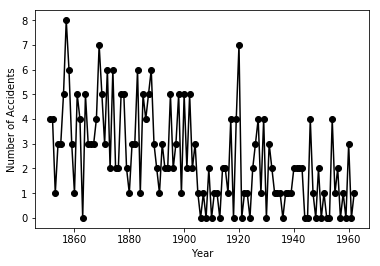

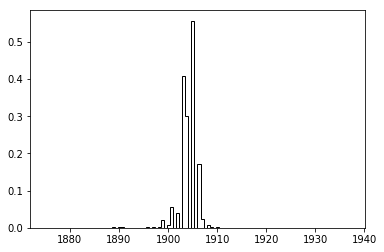

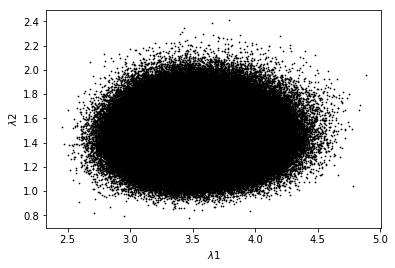

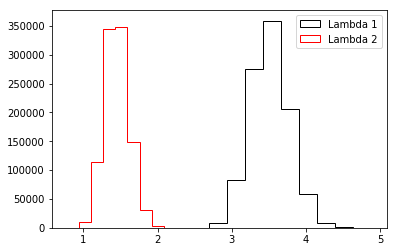

In [103]:
means,values = mcmc(3,data,steps=10**6)

In [198]:
np.sqrt(np.var(values[0])/len(values[0]))

0.0018833227721766126

## Part C

The already saved the plots

## Part D

In [197]:
print("These are the means for n0, l1, l2: ",np.mean(means[0]),np.mean(means[1]),np.mean(means[2]))

These are the means for n0, l1, l2:  1904.037045752954 3.516950944194107 1.450055796190292


## Part E

In [178]:
def partition(arr,bins):
    '''
    Breaks up an array into sub-arrays.
    If the array doesn't perfect break up, will just take the remainder at the end
    '''
    # makes list for N number of parameteres
    lists = [[] for _ in range(len(arr))]
          
    # Loops through each parameter and bins it up
    for i in range(len(lists)):
        # Putting the data into one array
        data = arr[i]
        
        # Placing the new array
        new_arr = lists[i]
        
        # How many time we can fully bin the array
        iterations = len(data)//bins
        
        # Partitions the array
        for j in range(iterations):
            partition = data[:bins]
            new_arr.append(partition)
            data = data[bins:]
        # Putting it back into the list 
        lists[i] = np.array(new_arr)
        
    return np.stack(lists,axis=0)


def meanError(arr,bins):
    '''
    Takes in an array resulting from an MCMC and caluclates the error associated with it 
    '''
    # This splits the array
    new_arr = partition(arr,bins)
    
    # Makes new arrays for the means
    means = [[] for _ in range(len(new_arr))]
    err = [[] for _ in range(len(new_arr))]
    
    # Takes the mean of each sub array and puts it into the mean array
    # Calculates the error through usual error estiamte: sqrt(variance/N)
    for i in range(len(means)):
        data = new_arr[i]
        for j in range(len(data)):
            means[i].append(np.mean(data[j]))
        err[i].append(np.sqrt(np.var(np.array(means[i]))/len(means[i])))
    err = np.array(err)
    means = np.array(means)
        
    return err,means


In [202]:
err, mean = meanError(values,bins=10000)
#print("Errors for n0, l1,l2: ",err[0],err[1],err[2])
err

array([[0.00198854],
       [0.00023766],
       [0.00018366]])

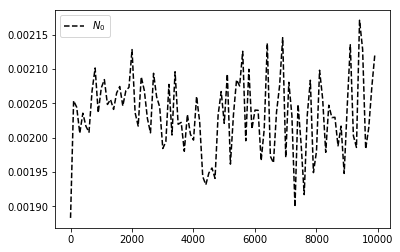

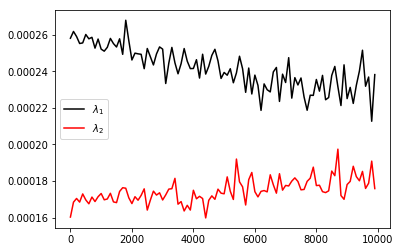

In [206]:
bins = np.arange(1,10000,step=100)

n0_err = []
l1_err = []
l2_err = []
error = []

for i in bins:
    err, means = meanError(values,i)
    n0_err.append(err[0])
    l1_err.append(err[1])
    l2_err.append(err[2])
n0_err = np.stack(n0_err,axis=0)
l1_err = np.stack(l1_err,axis=0)
l2_err = np.stack(l2_err,axis=0)

plt.plot(bins,n0_err,color='black',label='$N_0$',linestyle='--')
plt.legend(loc='best')
plt.show()

plt.plot(bins,l1_err,color='black',label='$\lambda_1$')
plt.plot(bins,l2_err,color='red',label='$\lambda_2$')
plt.legend(loc='best')
plt.show()
